In [8]:
## Importing libraries
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [9]:
import os
# folder  training-masker
train_mask_dir = os.path.join('./masker_dataset/Train/masker')

# folder training-nonmasker
train_unmask_dir = os.path.join('./masker_dataset/Train/bukanmasker')


# Directory with validation 
validation_mask_dir = os.path.join('./masker_dataset/Validation/masker')

# Directory with validation human pictures
validation_unmask_dir = os.path.join('./masker_dataset/Validation/bukanmasker')

**Berikut merupakan jumlah dataset pada tiap training dan validation**

In [10]:

print(f'TRAIN SET  MASK: {len(os.listdir(train_mask_dir))}')

print(f'TRAIN SET UNMASK: {len(os.listdir(train_unmask_dir))}')


print(f'VAL SET MASK: {len(os.listdir(validation_mask_dir))}')


print(f'VAL SET UNMASK: {len(os.listdir(validation_unmask_dir))}')

TRAIN SET  MASK: 2337
TRAIN SET UNMASK: 2259
VAL SET MASK: 494
VAL SET UNMASK: 500


**Bila akurasi sudah menembus 96 %, maka training  akan diberhentikan menggunakan Callback()**

In [4]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.96:
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

**Berikut merupakan Pre-processing dataset**

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi data TRAINING
train_datagen = ImageDataGenerator(
      rescale=1./255, #normalisasi gambar (dibagi dengan 255 karena rentang warna rgb rentang dari 0 hingga 255 pada python)
      rotation_range=40, # rotasi dalam derajat
      width_shift_range=0.2, # pergeseran lebar gambar
      height_shift_range=0.2, # pergeseran tinggi gambar
      shear_range=0.2, #distorsi
      zoom_range=0.2, # perbesaran (zoom)
      horizontal_flip=True, # diputar secara horizontal 
      fill_mode='nearest') # pixel baru di isi oleh pixel yang berdekatan

train_generator = train_datagen.flow_from_directory(
        'masker_dataset/Train/',  # letak folder gambar training
        target_size=(128, 128),  # seluruh gambar akan di resize menjadi 128x128
        batch_size=64, # jumlah gambar dalam satu batch sebanyak 64 pada Training
        class_mode='binary')  # binary class (0 dan 1)

#VALIDASI
validation_datagen = ImageDataGenerator(rescale=1/255) #normalisasi
validation_generator = validation_datagen.flow_from_directory(
        'masker_dataset/Validation/',  # letak folder gambar validasi
        target_size=(128, 128),   # seluruh gambar akan di resize menjadi 128x128
        batch_size=32,  # jumlah gambar dalam satu batch sebanyak 32 pada validasi
        class_mode='binary')  # binary class (0 dan 1)

Found 4596 images belonging to 2 classes.
Found 994 images belonging to 2 classes.


In [7]:
train_generator.class_indices

{'bukanmasker': 0, 'masker': 1}

**Kelas masker == 1 dan kelas non-masker =0**

In [8]:
validation_generator.class_indices

{'bukanmasker': 0, 'masker': 1}

**Membuat Arsitektur CNN**

In [12]:
model = tf.keras.models.Sequential([ 
    # 1
    tf.keras.layers.Conv2D(32, (2,2), activation='relu',input_shape=(128, 128, 3)),
    tf.keras.layers.BatchNormalization(axis=3),
    tf.keras.layers.MaxPooling2D(2, 2),
    # 2
    tf.keras.layers.SeparableConv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(axis=3),
    tf.keras.layers.MaxPooling2D(2, 2),
    # 3
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(axis=3),
    tf.keras.layers.MaxPooling2D(2, 2),
    # 4
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding ='same'),
    tf.keras.layers.BatchNormalization(axis=3),
    tf.keras.layers.MaxPooling2D(2, 2),
    # 5
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(axis=3),
    tf.keras.layers.MaxPooling2D(2, 2),

    #  Flatten
    tf.keras.layers.Flatten(),
    # 6- Dense layers
    tf.keras.layers.Dense(256, activation='relu'),
    # output
    tf.keras.layers.Dense(1, activation='sigmoid')

])

opt = tf.keras.optimizers.Adam(learning_rate=0.001) # menggunakan optimisasi adam dengan learning rate =0.001
model.compile(loss='binary_crossentropy', # loss menggunakan binary karena hanya ada dua class saja
                optimizer=opt,
                metrics=['accuracy']) 


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 32)      416       
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 61, 61, 32)       1344      
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 32)       128       
 hNormalization)                                        

**Dari summary diatas, Model yang dibuat hanya memiliki jumlah parameter 133377**

**Melakukan Training**

In [13]:
callbacks = myCallback()# memanggil class callback
history = model.fit(
      train_generator, 
      epochs=25, # jumlah maximum iterasi
      verbose=1, # agar iterasi setiap batch muncul
      validation_data = validation_generator, # menghitung validation score
      callbacks=[callbacks], # training diberhentikan menggunakan callback (bila akurasi melebihi 96 %)
      )

Epoch 1/25
72/72 [==============================] - 29s 384ms/step - loss: 0.3915 - accuracy: 0.8238 - val_loss: 0.6772 - val_accuracy: 0.4970
Epoch 2/25
72/72 [==============================] - 28s 389ms/step - loss: 0.3085 - accuracy: 0.8653 - val_loss: 0.8653 - val_accuracy: 0.5030
Epoch 3/25
72/72 [==============================] - 27s 368ms/step - loss: 0.2626 - accuracy: 0.8886 - val_loss: 0.6292 - val_accuracy: 0.5141
Epoch 4/25
72/72 [==============================] - 27s 371ms/step - loss: 0.2457 - accuracy: 0.8953 - val_loss: 0.4813 - val_accuracy: 0.9950
Epoch 5/25
72/72 [==============================] - 27s 380ms/step - loss: 0.2267 - accuracy: 0.9043 - val_loss: 0.2188 - val_accuracy: 0.9849
Epoch 6/25
72/72 [==============================] - 26s 356ms/step - loss: 0.2257 - accuracy: 0.9021 - val_loss: 0.3367 - val_accuracy: 0.7797
Epoch 7/25
72/72 [==============================] - 26s 358ms/step - loss: 0.2169 - accuracy: 0.9119 - val_loss: 0.0738 - val_accuracy: 0.9930

**Akurasi yang didapat setelah 25 iterasi adalah 95.1 %  pada training dan 99.8% pada testing (validation)**

**Model yang sudah dibuat harus disimpan lokal agar tidak perlu mengulangi training**

In [16]:
model.save('model_lomba.h5') # save model bernama model_lomba.h5

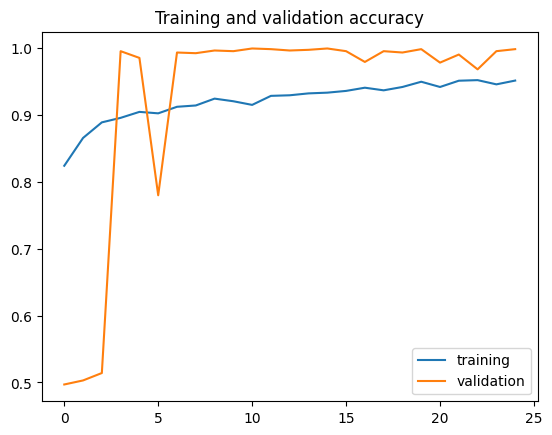

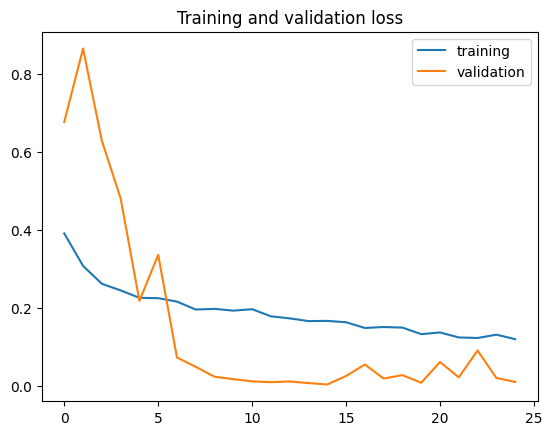

In [24]:
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # banyaknya epoch

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='training' )
plt.plot  ( epochs, val_acc, label='validation')
plt.title ('Training and validation accuracy'   )
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='training'  )
plt.plot  ( epochs, val_loss, label='validation'  )
plt.title ('Training and validation loss')
plt.legend()
plt.show()

**Melihat Setiap layer dari model CNN pada training** 

1/1 [==============================] - 0s 89ms/step


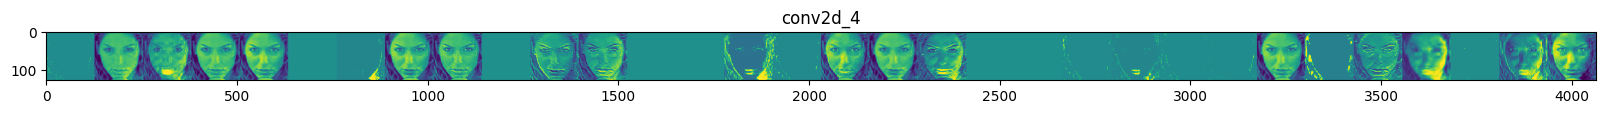

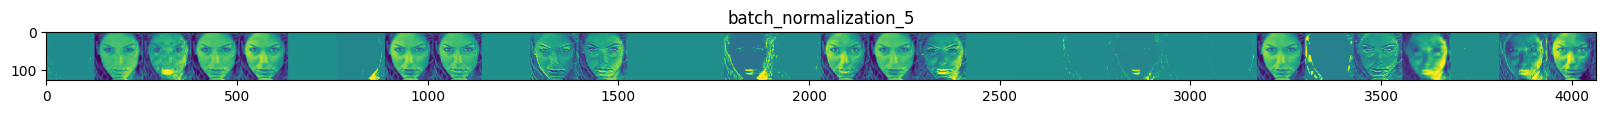

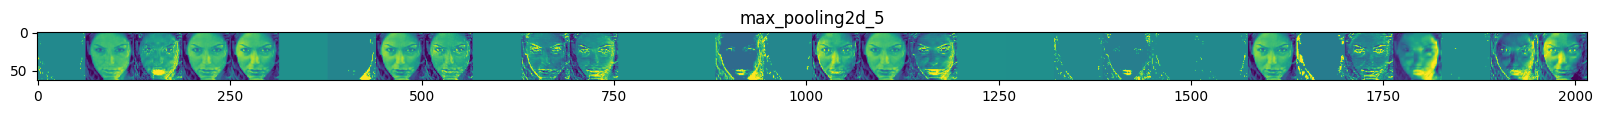

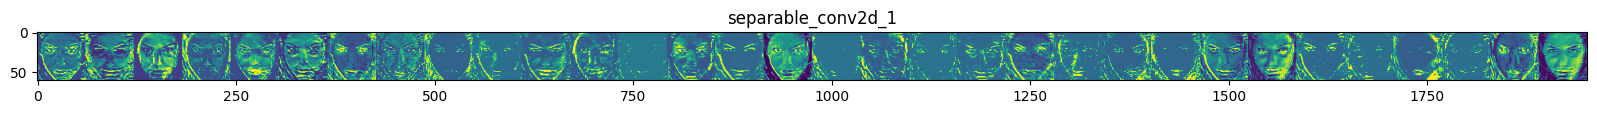

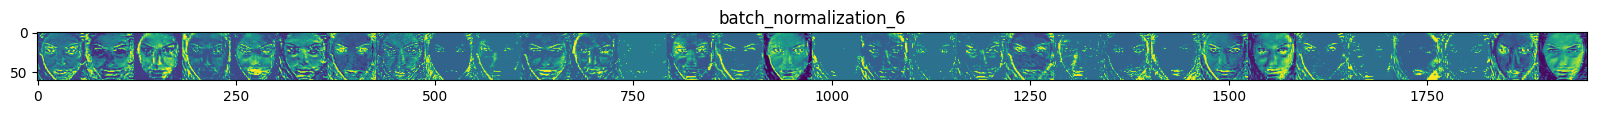

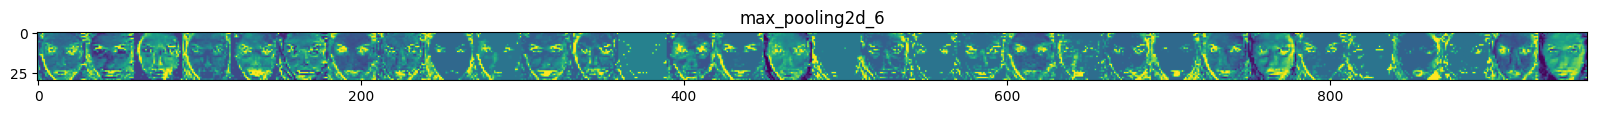

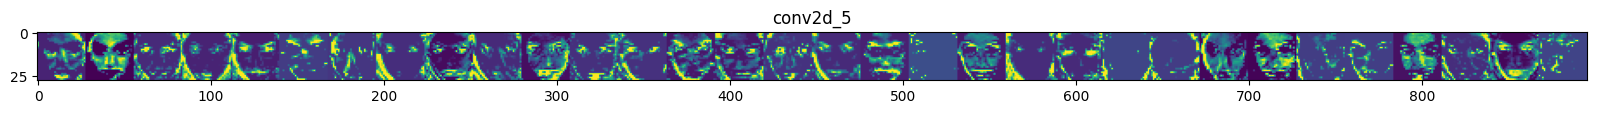

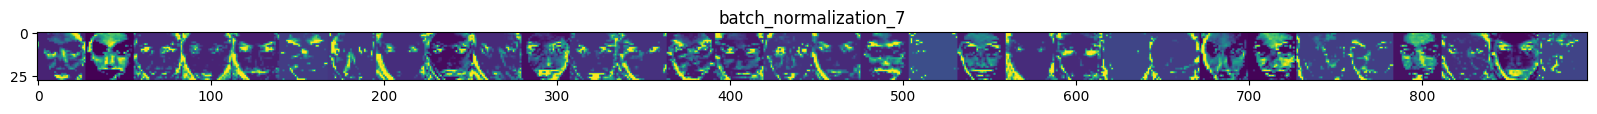

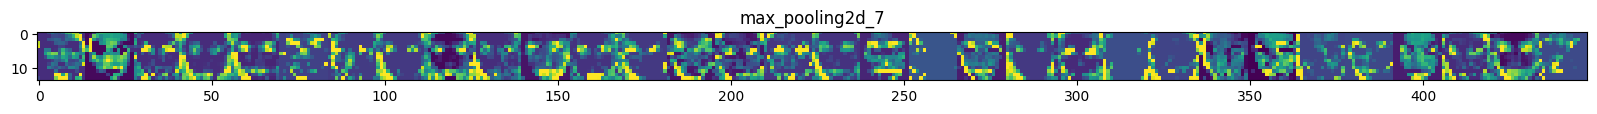

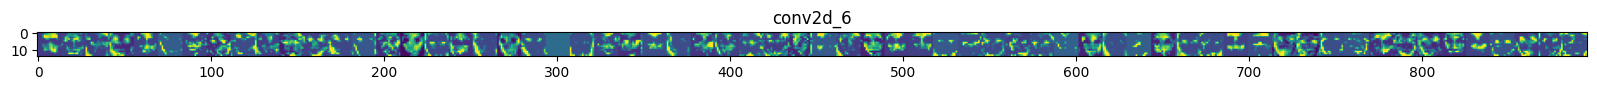

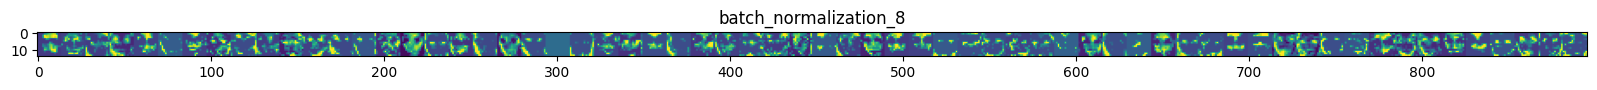

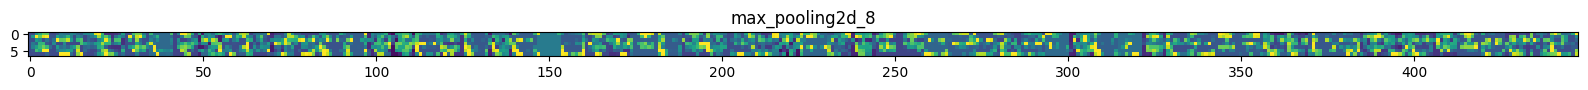

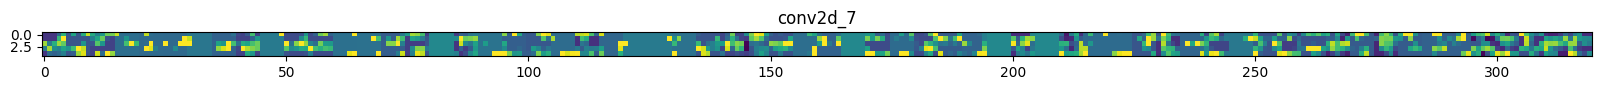

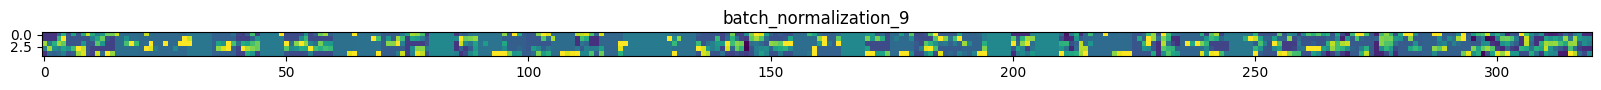

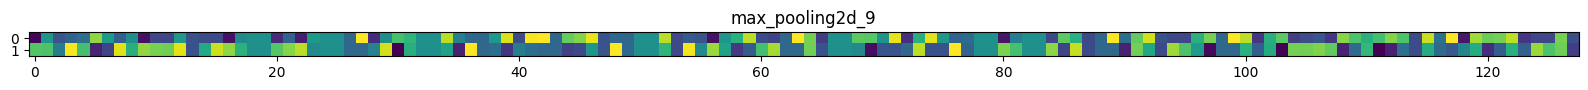

In [16]:
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img
import tensorflow as tf
import os
# representasi urutan layer pada CNN
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# gambar random dari training set
mask_img_files = [os.path.join(train_mask_dir, f) for f in os.listdir( train_mask_dir )]
unmask_img_files = [os.path.join(train_unmask_dir, f) for f in os.listdir( train_unmask_dir )]
img_path = random.choice(mask_img_files + unmask_img_files)
# gambar akan di resize menjadi (128,128) sesuai dengan input model CNN yang kami buat
img = load_img(img_path, target_size=(128, 128))
# mengubah gambar ke dalam bentuk array
x   = img_to_array(img)                      
x   = x.reshape((1,) + x.shape)
 # normalisasi gambar
x /= 255.0 

# running program
successive_feature_maps = visualization_model.predict(x)

#iterasi setiap layer pada model yang dibuat sehingga dapat di plot pada grafik
layer_names = [layer.name for layer in model.layers]

# Menampilkan dalam bentuk grafik
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:

    n_features = feature_map.shape[-1]  #jumlah fitur
    size       = feature_map.shape[ 1]  # shape dari feature map (1, size, size, n_features)
    
    # ubah gambar dalam grafik
    display_grid = np.zeros((size, size * n_features))
    
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= (x.std()+ 1e-5)
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # putar filter pada sumbu horizontal

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

# Melihat Uji Model

In [22]:
from tensorflow.keras.models import load_model
model = load_model("model_lomba.h5") # mengakses model yang kami buat

**Memilih files dari file explorer menggunakan  library tkinter**

In [23]:
import tkinter as tk
from tkinter import filedialog
root = tk.Tk()
root.withdraw()
# Hanya gambar pertipe png, jpg, atau jpeg yang dapat diterima
file_paths = filedialog.askopenfilenames( filetypes=[("Image Files", "*.png;*.jpg;*.jpeg")])


**Menampilkan Prediksi dari gambar yang bukan dari dataset training maupun validation**

1/1 [==============================] - 0s 17ms/step
Probabilits Memakai masker: 0.6317
class: Masker


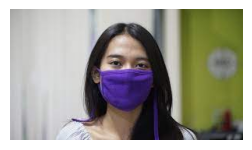

1/1 [==============================] - 0s 14ms/step
Probabilits Memakai masker: 0.9918
class: Masker


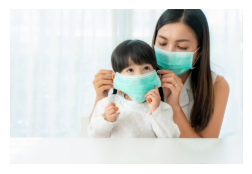

1/1 [==============================] - 0s 15ms/step
Probabilits Memakai masker: 0.0155
class: Bukan Masker


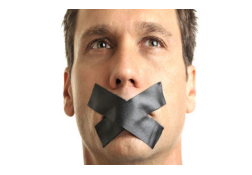

1/1 [==============================] - 0s 20ms/step
Probabilits Memakai masker: 0.0034
class: Bukan Masker


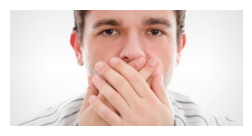

1/1 [==============================] - 0s 20ms/step
Probabilits Memakai masker: 0.1717
class: Bukan Masker


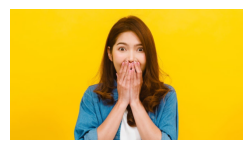

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for file_path in file_paths:
    image = tf.keras.preprocessing.image.load_img(file_path, target_size=(128, 128)) #ukuran gamber sesuai dengan input model CNN yang kami buat, yakni 128x128 pixel

    x= tf.keras.preprocessing.image.img_to_array(image)
    x /= 255
    x=np.expand_dims(x, axis=0)
    x= np.vstack([x])

    classes = model.predict(x, batch_size=6)
    predicted_class = classes[0]
    print("Probabilits Memakai masker: " +str(round(predicted_class[0], 4)))
    if classes[0]>0.51:
        print("class: Masker")
    else:
        print("class: Bukan Masker")

    # Menampilkan gambar
    img=mpimg.imread(file_path)
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off') 
    plt.show()